In [1]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

sns.set(style="whitegrid")


In [2]:
# Load both datasets
student_mat = pd.read_csv("student-mat (1).csv", sep=';')
student_por = pd.read_csv("student-por (1).csv", sep=';')

print("Math dataset shape:", student_mat.shape)
print("Portuguese dataset shape:", student_por.shape)

# Combine them
students = pd.concat([student_mat, student_por], axis=0).reset_index(drop=True)
print("Combined dataset shape:", students.shape)
students.head()


Math dataset shape: (395, 33)
Portuguese dataset shape: (649, 33)
Combined dataset shape: (1044, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
#CLEANING
def clean_data(df):
    print("Missing values before cleaning:")
    print(df.isnull().sum().sort_values(ascending=False).head())

    # Drop duplicates
    df = df.drop_duplicates()

    # Fill missing categorical and numeric data
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = df[col].fillna(df[col].median())

    # Create binary target: pass (1) if G3 ≥ 10, else fail (0)
    df['target'] = (df['G3'] >= 10).astype(int)
    print(" Data cleaning complete.")
    return df

students_clean = clean_data(students)
students_clean.head()

# Apply cleaning
students_clean = clean_data(students)

# Save cleaned dataset
students_clean.to_csv("cleaned_student_dataset.csv", index=False)

# Provide download link
from IPython.display import FileLink
FileLink("cleaned_student_dataset.csv")


Missing values before cleaning:
school     0
sex        0
age        0
address    0
famsize    0
dtype: int64
 Data cleaning complete.
Missing values before cleaning:
school     0
sex        0
age        0
address    0
famsize    0
dtype: int64
 Data cleaning complete.


c:\Users\adyan\Documents\ML_CUDA\ADA_MINI\cleaned_student_dataset.csv


===== Descriptive Statistics =====
               age         Medu         Fedu   traveltime    studytime  \
count  1044.000000  1044.000000  1044.000000  1044.000000  1044.000000   
mean     16.726054     2.603448     2.387931     1.522989     1.970307   
std       1.239975     1.124907     1.099938     0.731727     0.834353   
min      15.000000     0.000000     0.000000     1.000000     1.000000   
25%      16.000000     2.000000     1.000000     1.000000     1.000000   
50%      17.000000     3.000000     2.000000     1.000000     2.000000   
75%      18.000000     4.000000     3.000000     2.000000     2.000000   
max      22.000000     4.000000     4.000000     4.000000     4.000000   

          failures       famrel     freetime        goout         Dalc  \
count  1044.000000  1044.000000  1044.000000  1044.000000  1044.000000   
mean      0.264368     3.935824     3.201149     3.156130     1.494253   
std       0.656142     0.933401     1.031507     1.152575     0.911714   
m

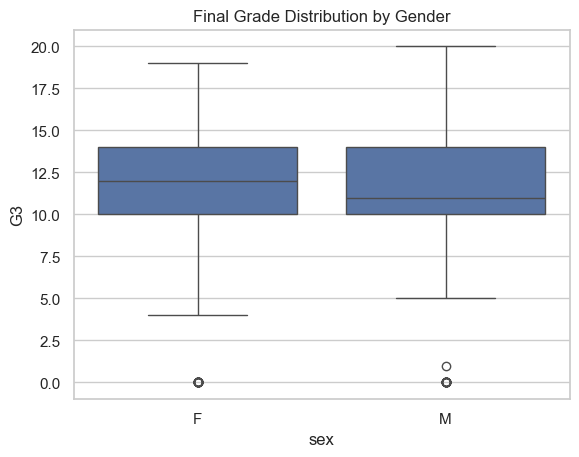

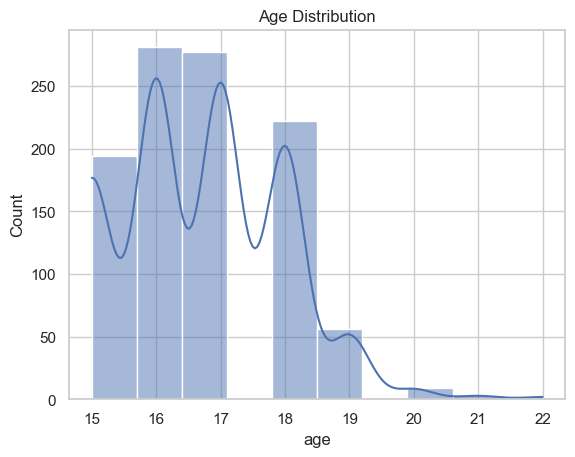

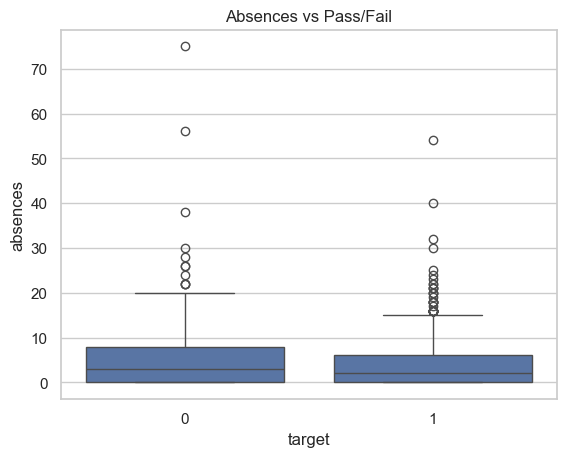

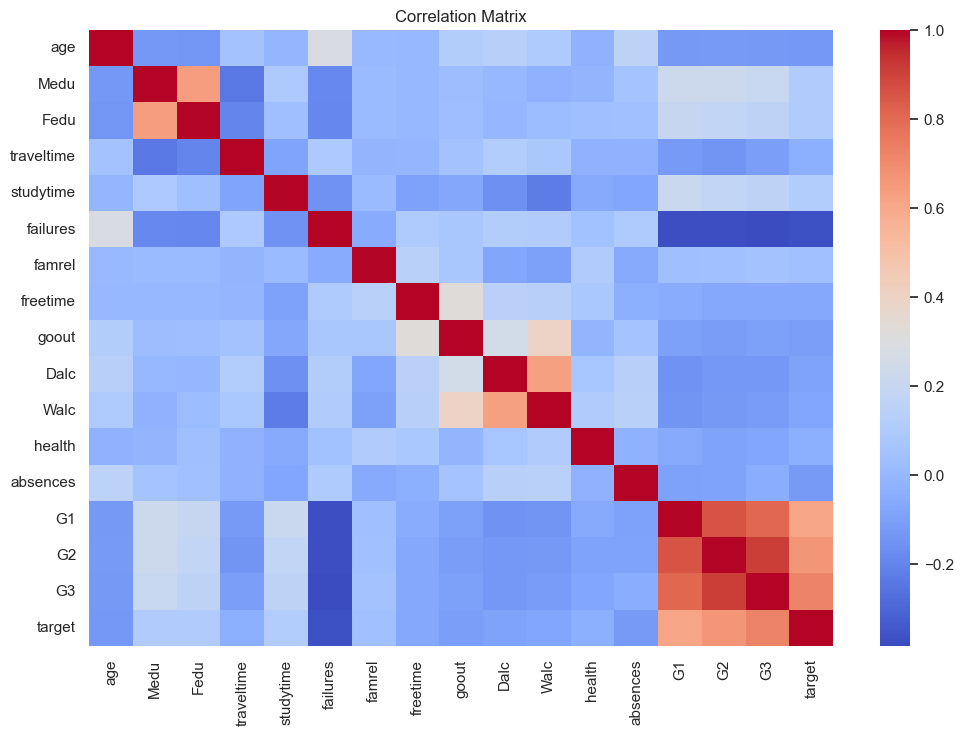

Descriptive analysis complete.


In [4]:
#Descriptive Analysis
def run_descriptive_analysis(df):
    print("\n===== Descriptive Statistics =====")
    print(df.describe())

    print("\n===== Target Distribution =====")
    print(df['target'].value_counts())

    # 1️ Gender vs Grade
    sns.boxplot(x='sex', y='G3', data=df)
    plt.title('Final Grade Distribution by Gender')
    plt.show()

    # 2️ Age distribution
    sns.histplot(df['age'], kde=True, bins=10)
    plt.title('Age Distribution')
    plt.show()

    # 3️ Absences vs Pass/Fail
    sns.boxplot(x='target', y='absences', data=df)
    plt.title('Absences vs Pass/Fail')
    plt.show()

    # 4️ Correlation Heatmap
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    print("Descriptive analysis complete.")

run_descriptive_analysis(students_clean)


In [5]:
#Predictive Modelling
def run_predictive_models(df):
    print("\n===== Running Predictive Models =====")

    # Drop duplicate targets
    if 'target' in df.columns:
        X = df.drop(columns=['G1', 'G2', 'G3', 'target'])
    else:
        X = df.drop(columns=['G1', 'G2', 'G3'])

    # Convert categorical columns
    X = pd.get_dummies(X, drop_first=True)
    y = df['G3']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "Random Forest": RandomForestRegressor(random_state=42)
    }

    results = {}
    best_model = None
    best_score = -float('inf')

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = r2_score(y_test, preds)
        results[name] = {
            "R2": score,
            "MAE": mean_absolute_error(y_test, preds),
            "RMSE": np.sqrt(mean_squared_error(y_test, preds))
        }
        print(f"{name} => R2: {score:.3f}, RMSE: {results[name]['RMSE']:.3f}")

        if score > best_score:
            best_score = score
            best_model = model

    # Save best model
    os.makedirs("models", exist_ok=True)
    joblib.dump(best_model, "models/best_model.pkl")
    print(" Best model saved to models/best_model.pkl")

    return results

model_results = run_predictive_models(students_clean)
model_results



===== Running Predictive Models =====
Linear Regression => R2: 0.108, RMSE: 3.638
Ridge Regression => R2: 0.111, RMSE: 3.632
Lasso Regression => R2: 0.131, RMSE: 3.591
Random Forest => R2: 0.178, RMSE: 3.491
 Best model saved to models/best_model.pkl


{'Linear Regression': {'R2': 0.1079047023702675,
  'MAE': 2.5362753368991826,
  'RMSE': np.float64(3.6380581829933787)},
 'Ridge Regression': {'R2': 0.11091503924362844,
  'MAE': 2.532027914834337,
  'RMSE': np.float64(3.6319147611956204)},
 'Lasso Regression': {'R2': 0.1306395578309547,
  'MAE': 2.5624468595408336,
  'RMSE': np.float64(3.5914014428900916)},
 'Random Forest': {'R2': 0.17847958608977987,
  'MAE': 2.4110612678192296,
  'RMSE': np.float64(3.4911876705325)}}

In [6]:
#Causal Inference (Propensity Score Matching)
def run_causal_inference(df):
    print("\n===== Causal Inference: Propensity Score Matching (PSM) =====")

    # Treatment: High study time (>=2 hrs)
    df['high_study'] = (df['studytime'] >= 2).astype(int)

    treatment = df['high_study']
    outcome = df['G3']

    # Confounders (controls)
    confounders = ['failures', 'absences', 'age', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
    X = df[confounders]

    # Standardize confounders
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Estimate propensity scores
    ps_model = LogisticRegression()
    ps_model.fit(X_scaled, treatment)
    df['propensity'] = ps_model.predict_proba(X_scaled)[:, 1]

    # Average Treatment Effect (via regression adjustment)
    df['intercept'] = 1
    model = sm.OLS(outcome, df[['intercept', 'high_study', 'propensity']])
    results = model.fit()
    print(results.summary())

    print("Causal inference (PSM-based) complete.")

run_causal_inference(students_clean)



===== Causal Inference: Propensity Score Matching (PSM) =====
                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     36.48
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           4.88e-16
Time:                        21:03:14   Log-Likelihood:                -2856.9
No. Observations:                1044   AIC:                             5720.
Df Residuals:                    1041   BIC:                             5735.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [7]:
# Reload the model to confirm it was saved properly
loaded_model = joblib.load("models/best_model.pkl")
print("Loaded model type:", type(loaded_model))


Loaded model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [8]:
# === Cross-validation for model robustness ===
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Prepare features and labels again
if 'target' in students_clean.columns:
    X = students_clean.drop(columns=['G1', 'G2', 'G3', 'target'])
else:
    X = students_clean.drop(columns=['G1', 'G2', 'G3'])

X = pd.get_dummies(X, drop_first=True)
y = students_clean['G3']

rf = RandomForestRegressor(random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')

print("Cross-validation R² scores:", cv_scores)
print("Average R² across folds:", cv_scores.mean().round(3))


Cross-validation R² scores: [ 0.34006055  0.17963735  0.25981265 -0.42117681  0.25459471]
Average R² across folds: 0.123


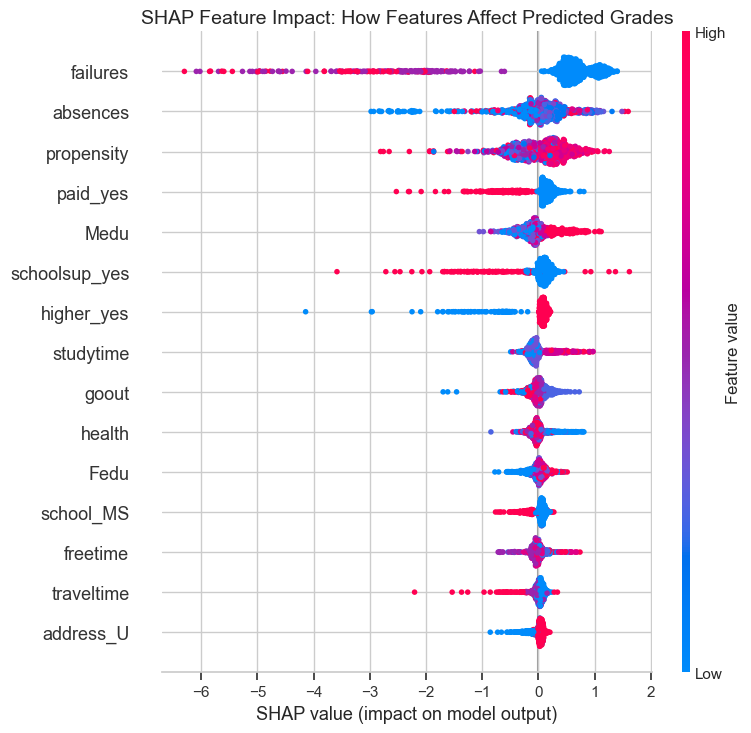

In [9]:
# === SHAP Feature Importance Visualization (Fixed) ===
# === SHAP Beeswarm Plot: Feature Impact on Predictions ===
import shap
import matplotlib.pyplot as plt
import numpy as np

# Ensure all features are numeric
X_numeric = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

# Fit model again (if not already trained)
rf.fit(X_numeric, y)

# SHAP Tree Explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_numeric)

# Create beeswarm plot
plt.title("SHAP Feature Impact: How Features Affect Predicted Grades", fontsize=14)
shap.summary_plot(shap_values, X_numeric, plot_type="dot", max_display=15)



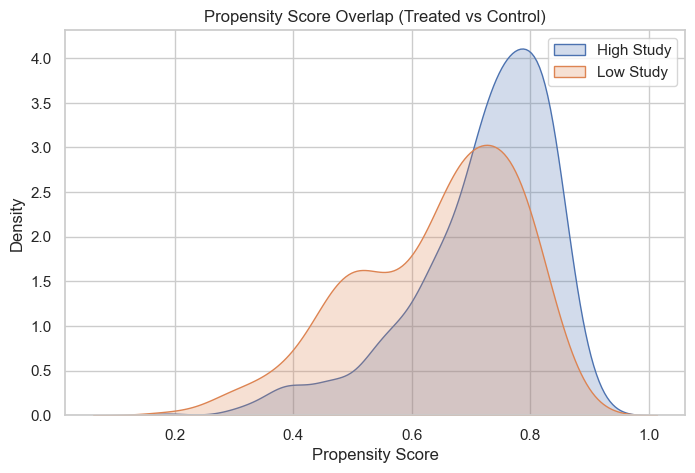

In [10]:
# === Propensity Score Overlap Visualization ===
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.kdeplot(students_clean[students_clean['high_study'] == 1]['propensity'], label='High Study', fill=True)
sns.kdeplot(students_clean[students_clean['high_study'] == 0]['propensity'], label='Low Study', fill=True)
plt.title("Propensity Score Overlap (Treated vs Control)")
plt.xlabel("Propensity Score")
plt.legend()
plt.show()


In [11]:
# === Inverse Probability Weighting (IPW) Causal Estimation ===
import statsmodels.api as sm

treatment = students_clean['high_study']
outcome = students_clean['G3']
propensity = students_clean['propensity']

# Compute IPW weights
weights = treatment / propensity + (1 - treatment) / (1 - propensity)

# Weighted regression
students_clean['intercept'] = 1
ipw_model = sm.WLS(outcome, students_clean[['intercept', 'high_study']], weights=weights)
ipw_results = ipw_model.fit()
print(ipw_results.summary())


                            WLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.005
Model:                            WLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     5.716
Date:                Mon, 17 Nov 2025   Prob (F-statistic):             0.0170
Time:                        21:03:32   Log-Likelihood:                -2937.3
No. Observations:                1044   AIC:                             5879.
Df Residuals:                    1042   BIC:                             5889.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.9206      0.168     65.103      0.0

In [12]:
# === Subgroup Causal Effects by Gender (Clean Version) ===
import statsmodels.api as sm

print("===== Heterogeneity Analysis by Gender =====")

for gender in students_clean['sex'].unique():
    sub = students_clean[students_clean['sex'] == gender].copy()  # ensure a deep copy
    print(f"\nGender: {gender} | N = {len(sub)}")

    # Treatment, outcome, and propensity
    t = sub['high_study']
    y = sub['G3']
    
    # Create design matrix safely
    X = sub[['propensity']].copy()
    X.loc[:, 'intercept'] = 1  # use .loc for safe column addition

    # Fit causal regression model
    model = sm.OLS(y, sm.add_constant(pd.concat([t, X['propensity']], axis=1)))
    results = model.fit()

    # Display summary of key coefficients
    print(results.summary().tables[1])


===== Heterogeneity Analysis by Gender =====

Gender: F | N = 591
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1719      1.121      6.400      0.000       4.971       9.373
high_study     0.4490      0.404      1.112      0.266      -0.344       1.242
propensity     5.3215      1.525      3.489      0.001       2.326       8.317

Gender: M | N = 453
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7760      0.800      5.972      0.000       3.204       6.348
high_study     0.8666      0.347      2.497      0.013       0.185       1.549
propensity     9.2186      1.242      7.422      0.000       6.778      11.659


In [13]:
# === ANOVA test: Does studytime group affect final grade? ===
from scipy.stats import f_oneway

groups = [students_clean[students_clean['studytime'] == s]['G3'] for s in sorted(students_clean['studytime'].unique())]
anova_result = f_oneway(*groups)


f_stat, p_val = f_oneway(*[group['G3'] for name, group in students_clean.groupby('studytime')])
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_val:.8f}")


if anova_result.pvalue < 0.05:
    print(" Significant difference in mean grades across studytime groups.")
else:
    print(" No significant difference between groups.")


F-statistic: 10.374
p-value: 0.00000099
 Significant difference in mean grades across studytime groups.


In [14]:
# === Subgroup Causal Effects by Prior Failures ===
import statsmodels.api as sm

print("===== Heterogeneity Analysis by Prior Failures =====")

# Group by 'failures' (number of past course failures)
for f in sorted(students_clean['failures'].unique()):
    sub = students_clean[students_clean['failures'] == f].copy()
    print(f"\nFailures: {f} | N = {len(sub)}")

    if len(sub) < 20:
        print(" Too few samples for reliable estimation. Skipping...")
        continue

    t = sub['high_study']
    y = sub['G3']
    X = sub[['propensity']].copy()
    X.loc[:, 'intercept'] = 1

    model = sm.OLS(y, sm.add_constant(pd.concat([t, X['propensity']], axis=1)))
    results = model.fit()
    print(results.summary().tables[1])


===== Heterogeneity Analysis by Prior Failures =====

Failures: 0 | N = 861
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8483      0.765     12.874      0.000       8.347      11.350
high_study     0.4088      0.270      1.512      0.131      -0.122       0.940
propensity     2.6507      1.090      2.431      0.015       0.511       4.790

Failures: 1 | N = 120
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0749      1.934      4.175      0.000       4.245      11.905
high_study     0.5096      0.749      0.681      0.498      -0.973       1.992
propensity     0.0969      3.006      0.032      0.974      -5.856       6.050

Failures: 2 | N = 33
                 coef    std err          t      P>|t|      [0.025      0.975]
----------


===== DoWhy Estimated Causal Effect =====
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                   
─────────────(E[G3|health,Walc,goout,failures,age,freetime,absences,Dalc])
d[high_study]                                                             
Estimand assumption 1, Unconfoundedness: If U→{high_study} and U→G3 then P(G3|high_study,health,Walc,goout,failures,age,freetime,absences,Dalc,U) = P(G3|high_study,health,Walc,goout,failures,age,freetime,absences,Dalc)

## Realized estimand
b: G3~high_study+health+Walc+goout+failures+age+freetime+absences+Dalc
Target units: ate

## Estimate
Mean value: 0.43295019157088127


===== Sensitivity Analysis (Add Unobserved Common Cause) =====


c:\PYTHON_13.9\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\PYTHON_13.9\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\PYTHON_13.9\Lib\site-packages\dowhy\causal_refuters\add_unobserved_common_cause.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_dev_y = np.std(y)[0]


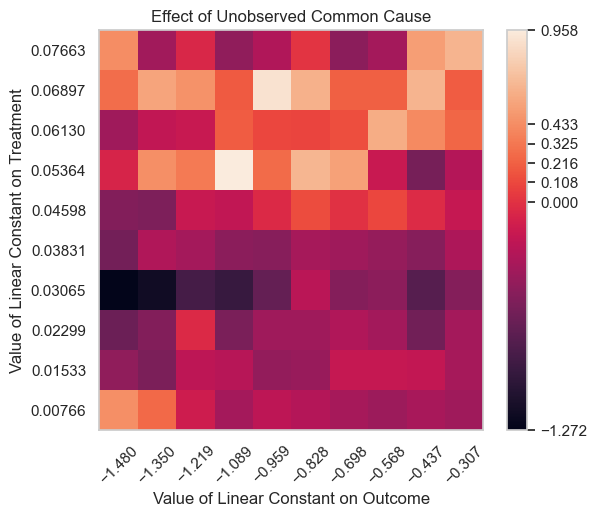

Refute: Add an Unobserved Common Cause
Estimated effect:0.43295019157088127
New effect:(np.float64(-1.2715085553068375), np.float64(0.9580576989114317))



In [15]:
# === Sensitivity Analysis using DoWhy (Modern Compatible Version) ===
!pip install dowhy --quiet

import dowhy
from dowhy import CausalModel

# Define treatment, outcome, and confounders
treatment = 'high_study'
outcome = 'G3'
confounders = ['failures', 'absences', 'age', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

# Build causal model
model = CausalModel(
    data=students_clean,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders
)

identified_estimand = model.identify_effect()
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

print("\n===== DoWhy Estimated Causal Effect =====")
print(estimate)

# Sensitivity analysis (modern compatible refuter)
print("\n===== Sensitivity Analysis (Add Unobserved Common Cause) =====")
res = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause"
)
print(res)


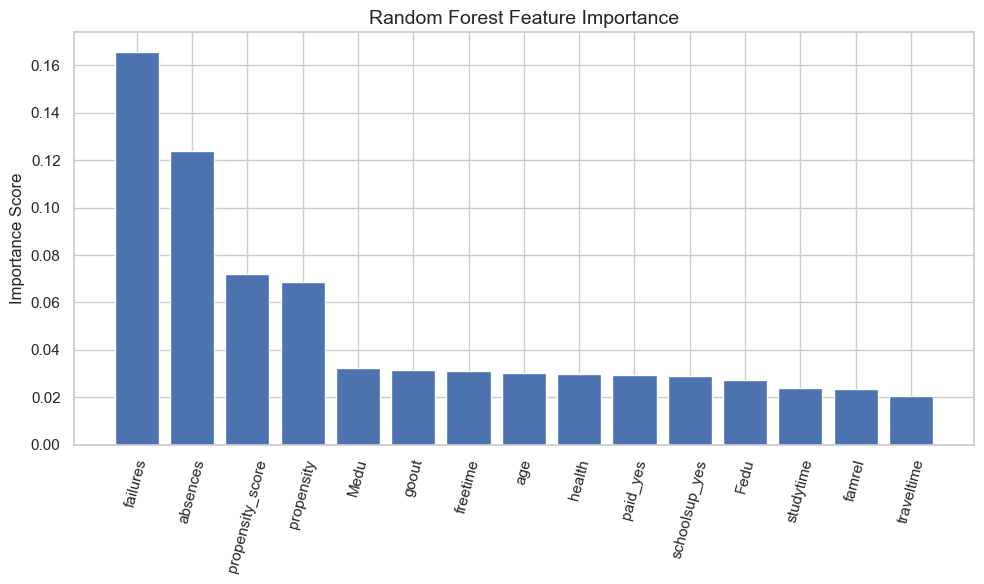

In [16]:
# === Random Forest Feature Importance Plot ===
import numpy as np
import matplotlib.pyplot as plt

# Ensure model and data are ready
if 'target' in students_clean.columns:
    X = students_clean.drop(columns=['G1', 'G2', 'G3', 'target'])
else:
    X = students_clean.drop(columns=['G1', 'G2', 'G3'])

X = pd.get_dummies(X, drop_first=True)
y = students_clean['G3']

rf.fit(X, y)

# Compute feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance", fontsize=14)
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), X.columns[indices][:15], rotation=75)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [17]:
# ==========================================================
#   RETRAIN MODEL USING REDUCED FEATURES
# ==========================================================

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load your reduced cleaned dataset
df = pd.read_csv("ResearchInformation3.csv")

# 2. Separate features and target
X = df.drop("G3", axis=1)
y = df["G3"]

# 3. Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 4. Preprocess pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# 5. Final training pipeline
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=42))
])

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. Train the model
model.fit(X_train, y_train)

# 8. Evaluate model performance
y_pred = model.predict(X_test)

print("========= TRAINED MODEL PERFORMANCE =========")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE  : {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R2   : {r2_score(y_test, y_pred):.4f}")

# 9. Save as new best_model.pkl
joblib.dump(model, "best_model_reduced.pkl")
print("\nSaved new model as best_model_reduced.pkl")


========= TRAINED MODEL PERFORMANCE =========
MAE  : 0.1072
MSE  : 0.0306
RMSE : 0.1748
R2   : 0.9181

Saved new model as best_model_reduced.pkl


In [18]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load new model
new_model = joblib.load("best_model_reduced.pkl")

# Load your reduced test dataset
test_df = pd.read_csv("ResearchInformation3.csv")

# Split features and labels
X_test_new = test_df.drop("G3", axis=1)
y_test_new = test_df["G3"]

# Predict
y_pred_new = new_model.predict(X_test_new)

# Evaluation
print("========= TEST DATASET ACCURACY =========")
print(f"MAE   : {mean_absolute_error(y_test_new, y_pred_new):.4f}")
print(f"MSE   : {mean_squared_error(y_test_new, y_pred_new):.4f}")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test_new, y_pred_new)):.4f}")
print(f"R²    : {r2_score(y_test_new, y_pred_new):.4f}")


========= TEST DATASET ACCURACY =========
MAE   : 0.0583
MSE   : 0.0123
RMSE  : 0.1109
R²    : 0.9648
